In [1]:
import cv2
import numpy as np
import time
import math
import pandas
from datetime import timedelta
import matplotlib.pyplot as plt

fps = np.array([1, 3, 5, 10, 15, 20])
fps2 = np.array([3, 15])
fps3 = np.array([3, 15, 20])

## Node data

### 1 node

In [2]:
''' RGB '''
# rgb unencoded 1024
rgb_bw = np.array([18, 42, 66, 150, 195, 270])
rgb_cpu_os = np.array([4, 6.3, 9.3, 17.8, 26.5, 38])
rgb_cpu_rt = np.array([0.3, 0.4, 0.6, 1.2, 1.8, 2.6])

# rgb encoded 1024
rgbe_bw = np.array([2.3, 5.6, 9.75, 19.3, 24.5, 41.5])
rgbe_cpu_os = np.array([2.5, 3.5, 6.5, 12.5, 14.5, 25.5])
rgbe_cpu_rt = np.array([0.29, 0.4, 0.68, 1.3, 1.9, 2.8])

# rgb unencoded 2048
rgb2_bw = np.array([169, 750, 830])
rgb2_cpu_os = np.array([15, 73, 87])
rgb2_cpu_rt = np.array([0.6, 2.8, 4])

''' LR '''
# lr unencoded 800p
lr_bw = np.array([31, 55, 110, 185, 260, 345])
lr_cpu_os = np.array([5.9, 8, 12.5, 24.5, 37, 49])
lr_cpu_rt = np.array([0.4, 0.55, 0.9, 1.9, 2.5, 3.5])

# lr encoded 800p
lre_bw = np.array([18, 71])
lre_cpu_os = np.array([5.8, 25])
lre_cpu_rt = np.array([1, 4.8])

''' Depth '''
# Depth 800p res SubPixel = T, Encoding = F
depth_bw = np.array([31, 52.5, 80, 196, 251, 326])
depth_cpu_os = np.array([6, 8.5, 12.8, 25.1, 37.9, 52.5])
depth_cpu_rt = np.array([0.5, 0.8, 1.3, 2.6, 3.8, 6.5])


### 2 nodes

In [3]:
''' RGB+LR '''
# RGB uenc, LR
rgblr_bw = np.array([49.5, 80, 160, 310, 440, 560])
rgblr_cpu_os = np.array([8, 13.5, 21.5, 43, 65, 96])
rgblr_cpu_rt = np.array([0.6, 1.05, 1.7, 3.3, 5.6, 7.4])

# RGB enc, LR
rgbelr_bw = np.array([35, 60, 79, 190, 274, 380])
rgbelr_cpu_os = np.array([6.5, 10.5, 17.5, 35.5, 52.5, 75.5])
rgbelr_cpu_rt = np.array([0.6, 1.05, 1.75, 3.45, 5.2, 10])

''' RGB+Depth '''
# RGB uenc, Depth SubPixel=T
rgbdepth_bw = np.array([49.5, 100, 160, 300, 440, 540])
rgbdepth_cpu_os = np.array([8, 13.6, 21.5, 44, 68.5, 99.94])
rgbdepth_cpu_rt = np.array([0.7, 1.75, 2.9, 5.65, 9.1, 14])

# RGB enc, Depth SubPixel=T
rgbedepth_bw = np.array([35, 55, 115, 195, 286, 365])
rgbedepth_cpu_os = np.array([7.5, 11.5, 18, 35.5, 56.5, 83.5])
rgbedepth_cpu_rt = np.array([0.75, 1.8, 3, 5.9, 9.3, 17])

''' LR+Depth '''
# LR uenc, Depth SubPixel=T
lrdepth_bw = np.array([62, 115, 150, 320, 480, 644])
lrdepth_cpu_os = np.array([8.5, 12.5, 20, 39, 58.5, 79.5])
lrdepth_cpu_rt = np.array([0.7, 0.99, 1.65, 3.2, 4.8, 7.5])

lredepth_bw = np.array([37, 63, 115, 225, 315, 400])
lredepth_cpu_os = np.array([7.7, 9.5, 15.3, 30.6, 45.5, 63.75])
lredepth_cpu_rt = np.array([0.99, 1.5, 2.4, 4.7, 7.03, 9.5])

### 3 nodes

In [4]:
''' RGB + LR + Depth '''
rgblrdepth_bw = np.array([85, 155, 235, 435, 645, 660])
rgblrdepth_cpu_os = np.array([12.5, 17.5, 29, 57, 94.5, 99.99])
rgblrdepth_cpu_rt = np.array([0.75, 1.95, 3.2, 6.4, 10, 10.5])

''' RGB enc + LR + Depth '''
rgbelrdepth_bw = np.array([51, 115, 195, 353, 515, 565])
rgbelrdepth_cpu_os = np.array([10.5, 15.5, 25.5, 50, 79, 99.99])
rgbelrdepth_cpu_rt = np.array([0.8, 2, 3.3, 6.5, 10.5, 13])

''' RGB enc + LR enc + Depth '''
rgbelredepth_bw = np.array([39, 65, 115, 235, 315, 435])
rgbelredepth_cpu_os = np.array([8.5, 12.3, 20.5, 40, 62.5, 94.5])
rgbelredepth_cpu_rt = np.array([1.65, 2.5, 4.1, 8, 11.8, 21])

# Predictions

In [5]:
def get_poly(x, y):
    P = np.polyfit(x,y,1)
    return P

def predict(poly, var):
    equ = np.poly1d(poly)
    prediction = equ(var)
    return prediction

In [6]:
nodes = [rgb_bw, rgbe_bw, rgb2_bw, lr_bw, lre_bw, depth_bw]
nodes_pred = [[13.25, 4.25], [1.94, -0.31], [40.63, 68.34], [16.5, 15.8], [4.42, 4.75], [16.08, 11.39]]
x_axis = [fps, fps, fps3, fps, fps2, fps]

nodes_2 = [rgblr_bw, rgbelr_bw, rgbdepth_bw, rgbedepth_bw, lrdepth_bw, lredepth_bw]
# diff for 2 nodes [1.41987835, 0.91359489]
base = predict([1.42, 0.91], fps)
mapping = [ [0, 3], [1, 3], [0, 5], [1, 5], [3, 5], [4, 5] ]

nodes_3 = [rgblrdepth_bw, rgbelrdepth_bw, rgbelredepth_bw]
mapping_3 = [[0, 3, 5], [1, 3, 5], [1, 4, 5]]

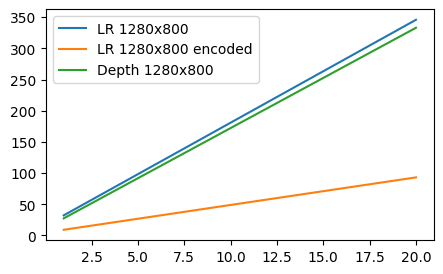

In [10]:
x = fps

fig = plt.figure(figsize = (5, 3))
val1 = predict(nodes_pred[3], x)
val2 = predict(nodes_pred[4], x)
val3 = predict(nodes_pred[5], x)

# plt.plot(x, val1, x, val2)
plt.plot(x, val1, x, val2, x, val3 )

# plt.legend(['RGB 1024x1024', 'RGB 1024x1024 encoded'])
plt.legend(['LR 1280x800', 'LR 1280x800 encoded', 'Depth 1280x800'])
plt.show()

In [118]:
''' get 3 degree polynomial for single nodes '''
# for i in range(6):
#     node = nodes[i]
#     x = x_axis[i]
#     P = np.polyfit(x, node, 3)
#     print(P)

' get 3 degree polynomial for single nodes '

In [109]:
'''bandwidth consumption comparison'''
# arr1 = nodes[0]
# arr2 = predict(nodes_pred[2], fps)
# arr3 = nodes[1]

# for i in range(6):
#     print(arr2[i]/arr1[i])
    

'bandwidth consumption comparison'

[ -3.53   7.13  11.79 -23.81   1.59   6.99]


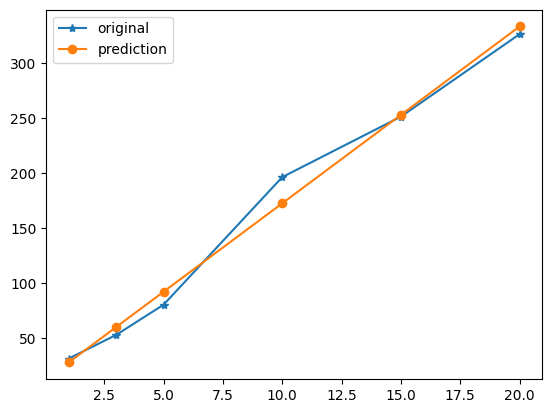

In [97]:
'''
1 node comparison to predicted values
'''

opt = 5
x = x_axis[opt]

orig = nodes[opt]
pred = predict(nodes_pred[opt], x)
diff = pred - orig
print(diff)

plt.plot(x, orig, '*-', x, pred, 'o-')
plt.legend(['original', 'prediction'])
plt.show()

[1.41987835 0.91359489]


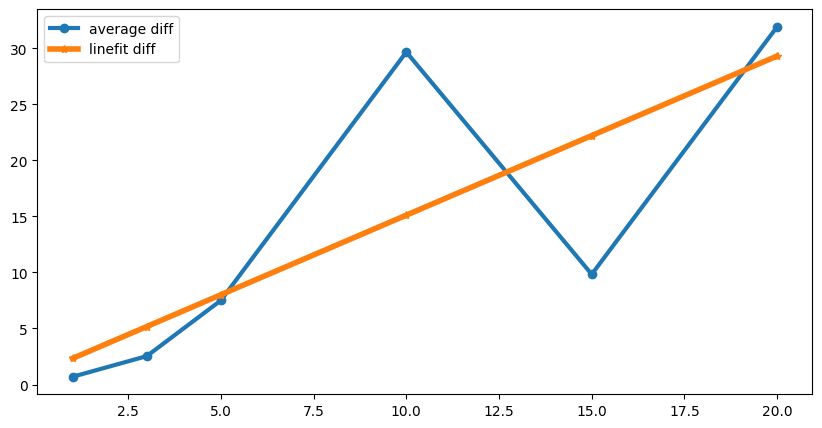

In [82]:
'''
getting line equation for differences between original 2 node values and mathematical combination of 1 nodes
(finding out the baseline)
'''
diffs = [
    [-0.5, 17, 16, 25, 15, 55],
    [-1.7, 0.6, 40.75, 14.3, 10.5, 6.5],
    [-0.5, -5.5, -14, 46, 6, 56],
    [-1.7, 3.1, -25.25, 20.3, -10.5, 2.5],
    [0, -7.5, 40, 61, 31, 27],
    [8.55, 7.5, -12.46, 11.41, 7, 44.53]
]

avg = []
for i in range(6):
    # get average of differences across a single fps
    vals = []
    for diff in diffs:
        vals.append(diff[i])
    # get average of differences across a single fps
    avg.append(np.mean(vals))

coff = get_poly(fps, avg)
pred_avg = predict(coff, fps)
print(coff)

# plot the original average and predicted average
fig = plt.figure(figsize = (10, 5))

# for diff in diffs:
#     plt.plot(fps, diff, '*-')
plt.plot(fps, avg, 'o-', linewidth=3)
plt.plot(fps, pred_avg, '*-', linewidth=4)
plt.legend(['average diff', 'linefit diff'])
plt.show()

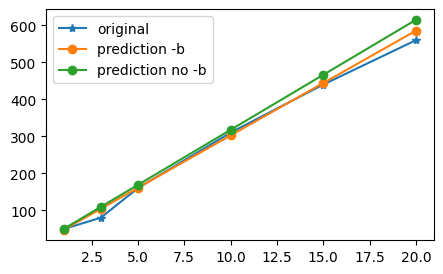

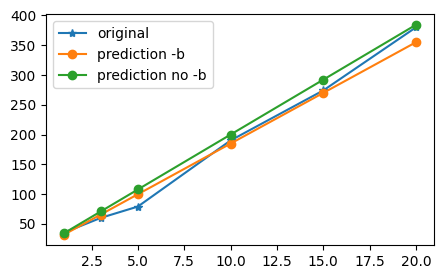

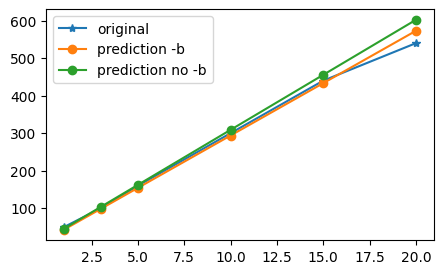

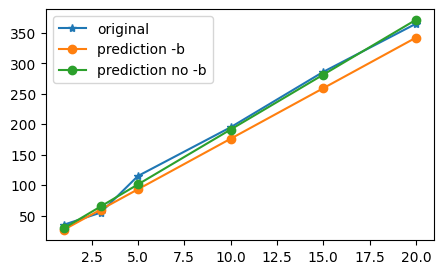

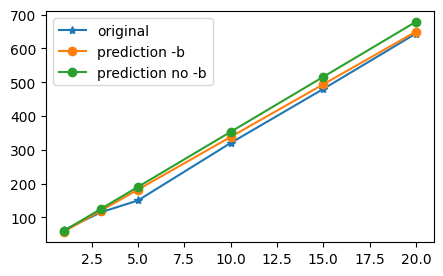

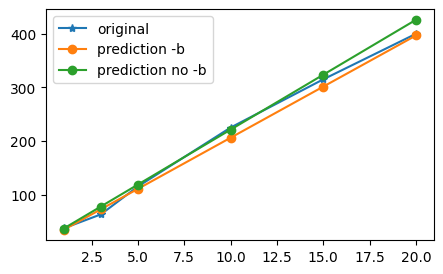

In [96]:
'''
2 nodes comparison to predicted values
'''
x = fps

for opt in range(6):
    fig = plt.figure(figsize = (5, 3))
    opt_1 = mapping[opt][0]
    opt_2 = mapping[opt][1]


    orig = nodes_2[opt]
    val1 = predict(nodes_pred[opt_1], x)
    val2 = predict(nodes_pred[opt_2], x)
    pred_wo = val1 + val2
    pred_w = val1 + val2 - base
    diff = pred - orig

    plt.plot(x, orig, '*-', x, pred_w, 'o-', x, pred_wo, 'o-')
    plt.legend(['original', 'prediction -b', 'prediction no -b'])
    plt.show()

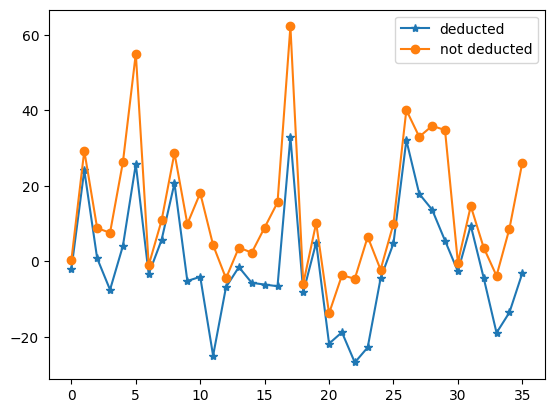

In [84]:
'''
comparing effects of base line deduction
'''

x = fps
with_base = np.array([])
without_base = np.array([])

for opt in range(6):
    opt_1 = mapping[opt][0]
    opt_2 = mapping[opt][1]
    
    orig = nodes_2[opt]
    val1 = predict(nodes_pred[opt_1], x)
    val2 = predict(nodes_pred[opt_2], x)
    pred = val1 + val2
    diff = pred - orig
    without_base = np.append(without_base, diff)
    diff = pred - orig - base
    with_base = np.append(with_base, diff)

# print(with_base)
# print(without_base)
    
plt.plot(with_base, '*-', without_base, 'o-')
plt.legend(['deducted', 'not deducted'])
plt.show()

# when baseline is deducted, predicted values tend to fall below original more often (Fav:4, Neu:0,2, Det:1,3,5)

[ -7.73  13.93  25.59  54.74  73.89 288.04] [-12.39   3.59   9.57  24.52  29.47 229.42]


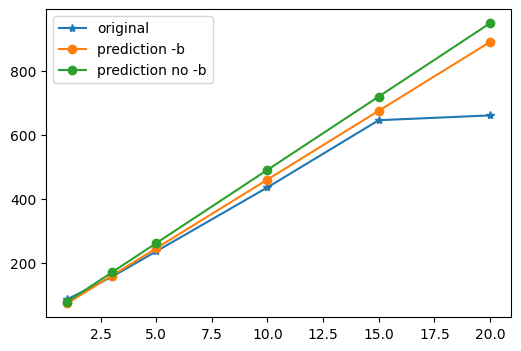

[ 10.4   15.44   4.48  19.08  29.68 152.28] [  5.74   5.1  -11.54 -11.14 -14.74  93.66]


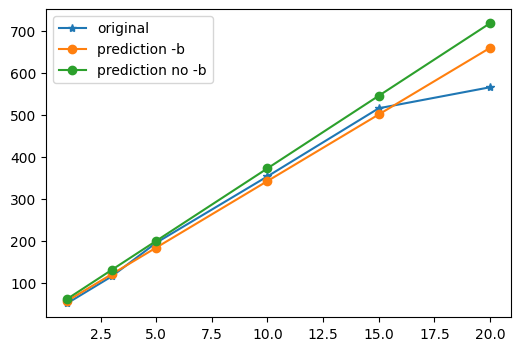

[-0.73 18.15 13.03  5.23 37.43 29.63] [ -5.39   7.81  -2.99 -24.99  -6.99 -28.99]


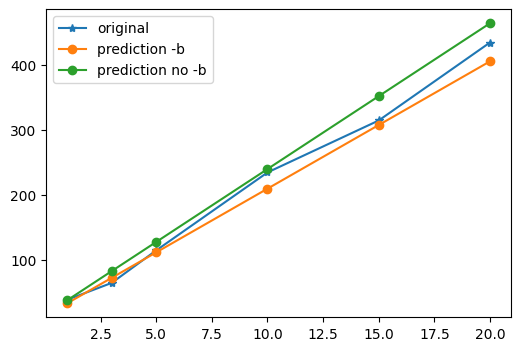

In [99]:
'''
3 nodes comparison to predicted values
'''
x = fps

for opt in range(3):
    fig = plt.figure(figsize = (6, 4))
    opt_1 = mapping_3[opt][0]
    opt_2 = mapping_3[opt][1]
    opt_3 = mapping_3[opt][2]


    orig = nodes_3[opt]
    val1 = predict(nodes_pred[opt_1], x)
    val2 = predict(nodes_pred[opt_2], x)
    val3 = predict(nodes_pred[opt_3], x)

    pred_wo = val1 + val2 + val3
    pred_w = val1 + (val2 - base) + (val3 - base)
    diff1 = pred_wo - orig
    diff2 = pred_w - orig
    print(diff1, diff2)

    plt.plot(x, orig, '*-', x, pred_w, 'o-', x, pred_wo, 'o-')
    plt.legend(['original', 'prediction -b', 'prediction no -b'])
    plt.show()

# when baseline is deducted, predicted values tend to fall below original more often (Fav:4, Neu:0,2, Det:1,3,5)

In [ ]:
# without deduction, with deduction

[ -7.73  13.93  25.59  54.74  73.89 288.04] [-12.39   3.59   9.57  24.52  29.47 229.42]
[ 10.4   15.44   4.48  19.08  29.68 152.28] [  5.74   5.1  -11.54 -11.14 -14.74  93.66]
[-0.73 18.15 13.03  5.23 37.43 29.63] [ -5.39   7.81  -2.99 -24.99  -6.99 -28.99]

In [100]:
'''
getting polynomial for prediction
'''

# nodes = [rgb_bw, rgbe_bw, rgb2_bw, lr_bw, lre_bw, depth_bw]
opt = 0
data_points = nodes[opt]
x = x_axis[opt]
Po = get_poly(x,data_points)
print(Po)

equ = np.poly1d(Po)
print( equ, equ(fps) )

[13.24817518  4.26642336]
 
13.25 x + 4.266 [ 17.51459854  44.01094891  70.50729927 136.74817518 202.98905109
 269.22992701]


In [101]:
Po2 = [0.2, -0.03]
print( predict(Po2, x) )

[0.17 0.57 0.97 1.97 2.97 3.97]


In [102]:
# predict_fps = np.arange(1, 21, 1, dtype=int)
# plt.plot(predict_fps, equ(predict_fps), '*-', fps, data_points, 'o', predict_fps, equ2(predict_fps), '*-')
# plt.legend(['pre1', 'orig', 'pre2'])
# plt.show()

In [29]:
# import sys, os
# os.system("python camera_model.py")